## Estimate mass

Use overdensity to estimate descendant cluster mass.

In [1]:
import pandas as pd
import numpy as np
import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from scipy.optimize import curve_fit

from methods import factor_h
from methods import z_distort
from methods import get_protoclusters
from methods import r2
from methods import fit_func
from overdensity_cylinder import overdensity_cylinder

h = 0.673
L = 480.279 / h

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory = 'output/'

Load data

In [2]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97']#,'8p22','8p93','9p72']
zees = [float(z.replace('p','.')) for z in redshifts]

In [3]:
gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, z in enumerate(redshifts):
    print i, z
    
    gals_sfr[i] = pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), 
                              skiprows=122, skipfooter=1, engine='python')
    
    gals_mstar[i] = pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), 
                                skiprows=122, skipfooter=1, engine='python')
    
    
for i, z in enumerate(zees):
    for gals in [gals_sfr, gals_mstar]:
        gals[i] = z_distort(factor_h(gals[i], h), z, L)

#         print "Filling in NaN values..."
        gals[i].ix[np.isnan(gals[i]['z0_haloId']), 'z0_haloId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_centralId']), 'z0_centralId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_central_mcrit200']), 'z0_central_mcrit200'] = 0
    

0 2p07
1 3p10
2 3p95
3 5p03
4 5p92
5 6p97


/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


### $R \;/\; \delta_{z}$  stats

In [10]:
# cylinder_mstar = {z: {'cstats': None, 'clusters': None} for z in zees}
# cylinder_sfr =  {z: {'cstats': None, 'clusters': None} for z in zees}
# cylinder_sfr5 =  {z: {'cstats': None, 'clusters': None} for z in zees}

# for i, z in enumerate(zees):
#     print i, z
    
#     pcs  = get_protoclusters(gals_mstar[i], L, cluster_lim=1e3)
#     cylinder_mstar[z]['clusters'] = pcs['clusters']
#     cylinder_mstar[z]['cstats'] = overdensity_cylinder(gals_mstar[i], pcs['coods'], L=L, R=10, dc=10)

#     pcs = get_protoclusters(gals_sfr[i], L, cluster_lim=1e3)
#     cylinder_sfr[z]['clusters'] = pcs['clusters']
#     cylinder_sfr[z]['cstats'] = overdensity_cylinder(gals_sfr[i], pcs['coods'], L=L, R=10, dc=10)

#     gals_sfr5 = gals_sfr[i][gals_sfr[i]['zn_sfr'] > 5].reset_index(drop=True)
#     pcs = get_protoclusters(gals_sfr5, L, cluster_lim=1e3)
#     cylinder_sfr5[z]['clusters'] = pcs['clusters']
#     cylinder_sfr5[z]['cstats'] = overdensity_cylinder(gals_sfr5, pcs['coods'], L=L, R=10, dc=10)

    
# pcl.dump(cylinder_mstar, open('data/cylinder_mstar.pcl','w'))
# pcl.dump(cylinder_sfr, open('data/cylinder_sfr.pcl','w'))
# pcl.dump(cylinder_sfr5, open('data/cylinder_sfr5.pcl','w'))

cylinder_mstar = pcl.load(open('data/cylinder_mstar.pcl','r'))
cylinder_sfr = pcl.load(open('data/cylinder_sfr.pcl','r'))
cylinder_sfr5 = pcl.load(open('data/cylinder_sfr5.pcl','r'))

0 2.07
1 3.1
2 3.95
3 5.03
4 5.92
5 6.97


save all properties in a single array to allow fit

In [12]:
feature_array = [None] * len(zees)
predictor_array = [None] * len(zees)

cylinder = cylinder_sfr

for i, z in enumerate(zees):
    
    cstats = cylinder[z]['cstats']
    cmass = cylinder[z]['clusters']

    x = np.zeros((cstats.shape[0], 2))
    
    x[:,0] = cstats[:,0].flatten() # dgal
    x[:,1] = z

    y = np.array(cmass['z0_central_mcrit200']) #/ 1e3
    
    feature_array[i] = x
    predictor_array[i] = y
    
    
feature_array = np.vstack(feature_array)
predictor_array = np.hstack(predictor_array)

Can only fit above a given $\delta_{\mathrm{gal}}$:

In [13]:
fit_mask = feature_array[:,0] > 4.5

Fit...

In [14]:
popt, pcov = curve_fit(fit_func, feature_array[fit_mask,:].T, predictor_array[fit_mask], maxfev=20000)
print popt

[  1.46303564e+03  -1.07735386e+00   2.62779888e+00   1.75204996e+04]


Evaluate fit 

In [17]:
print "$R^{2} (polynomial)$:",r2(predictor_array[fit_mask], 
        fit_func(feature_array[fit_mask].T, popt[0], popt[1], popt[2], popt[3]))

$R^{2} (polynomial)$: 0.54707048053


Compare to Chiang+13 fit:

Plot fit

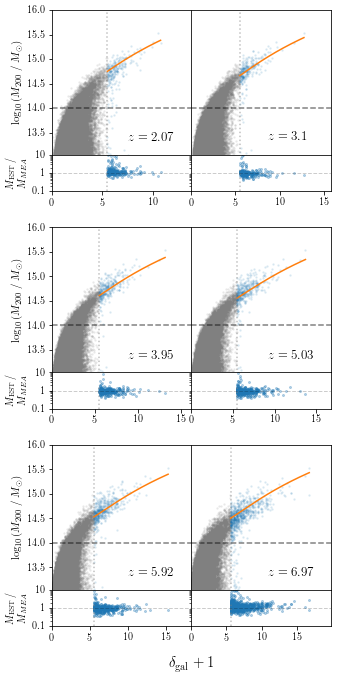

In [31]:
fig = plt.figure(figsize=(5,12))

gs1 = gridspec.GridSpec(18, 2)
gs1.update(wspace=0, hspace=0)

ax1 = fig.add_subplot(gs1[0:4,0])
ax2 = fig.add_subplot(gs1[0:4,1])
ax3 = fig.add_subplot(gs1[6:10,0])
ax4 = fig.add_subplot(gs1[6:10,1])
ax5 = fig.add_subplot(gs1[12:16,0])
ax6 = fig.add_subplot(gs1[12:16,1])

ax1b = fig.add_subplot(gs1[4,0])
ax2b = fig.add_subplot(gs1[4,1])
ax3b = fig.add_subplot(gs1[10,0])
ax4b = fig.add_subplot(gs1[10,1])
ax5b = fig.add_subplot(gs1[16,0])
ax6b = fig.add_subplot(gs1[16,1])

axes = [ax1,ax2,ax3,ax4,ax5,ax6]
axes_b = [ax1b,ax2b,ax3b,ax4b,ax5b,ax6b]

def scale(x):
    return np.log10(x * 1e10)


for ax, axb, z in zip(axes, axes_b, zees):
    
    ax.text(0.55, 0.1, '$z = %s$'%z, transform=ax.transAxes, size=13)
    
    z_mask = (feature_array[:,1] == z) & fit_mask
    z_mask_all = (feature_array[:,1] == z) & (~fit_mask)
    
    # plot all points
    ax.plot(feature_array[z_mask_all,0]+1, scale(predictor_array[z_mask_all]), 
            '.', markersize=3, alpha=0.1, c='grey')

    ax.plot(feature_array[z_mask,0]+1, scale(predictor_array[z_mask]), '.', markersize=3, alpha=0.1)
    
    # plot fitted points
    dgal_range = np.linspace(feature_array[z_mask,0].min(), feature_array[z_mask,0].max(), np.sum(z_mask))
    
    ax.plot(dgal_range+1, scale(fit_func(np.vstack([dgal_range, feature_array[z_mask,1]]),
                             popt[0], popt[1], popt[2], popt[3])))
    
    # residuals
    axb.semilogy(feature_array[z_mask,0]+1, 10**scale(fit_func(np.vstack([feature_array[z_mask,0], 
                                                                  feature_array[z_mask,1]]),
                             popt[0], popt[1], popt[2], popt[3])) / \
                 10**scale(predictor_array[z_mask]), '.', markersize=4, alpha=0.3)
    
    
    
    ax.hlines(np.log10(1e14), 0, feature_array[z_mask,0].max() + 4, alpha=0.5, 
              linestyle='dashed', color='black',zorder=10)
    
    axb.hlines(1, 0, feature_array[z_mask,0].max() + 4, alpha=0.2, 
              linestyle='dashed', linewidth=1, color='black',zorder=10)
    
    ax.vlines(feature_array[z_mask,0].min() + 1, 13, 16, alpha=0.5, linestyle='dotted', color='grey',zorder=10)
    axb.vlines(feature_array[z_mask,0].min() + 1, 0.1, 2, alpha=0.5, linestyle='dotted', color='grey',zorder=10)

    for axe in [ax,axb]:
        axe.set_xlim(0,feature_array[z_mask,0].max() + 4)
    
    ax.set_ylim(np.log10(1.1e13), 16)
    axb.set_ylim(0.1,10)
    
    ax.set_xticklabels([])
    
    
for ax in [ax2, ax4, ax6, ax2b, ax4b, ax6b]:
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    
for ax, axb in zip([ax1,ax3,ax5],[ax1b,ax3b,ax5b]):
    ax.set_ylabel('$\mathrm{log_{10}} (M_{200}\,/\;M_{\odot})$', size=11)
    axb.set_ylabel('$M_{\mathrm{EST}}\,/$\n$\;M_{MEA}$', size=10)
    axb.set_yticklabels(['','$0.1$','$1$','$10$'])
    
    
ax5b.text(0.84, -0.55, '$\delta_{\mathrm{gal}} + 1$', transform = ax5.transAxes, size=15)

# plt.savefig(out_directory+'mass_fit.png', bbox_inches='tight', dpi=300)